In [16]:
!/home/ps2958/.miniconda3/envs/py36/bin/python unidirectionalrrt.py

Figure(640x480)
n = 81


In [3]:
from __future__ import division
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import numpy as np
import random, math
from obstacles import Range, Point, Line, Obstacle, Obstacles

from importlib import reload

import KDTree
from utilities import *

In [4]:
def gen_valid_rand(valid_function):
    """ Generates a valid q_rand \in Q_free given a validity function """
    tmp = np.random.random(2) * span*1.1 + minp - span*0.05
    while not valid_function(*tmp):
        tmp = np.random.random(2) * span*1.1 + minp - span*0.05
    return tmp

In [9]:
# obstacle_path, goal_path = "../hw3/world_obstacles.txt", "../hw3/goal.txt"
obstacle_path, goal_path = "world_obstacles.txt", "start_goal.txt"

step_size   = 50
path        = get_obstacle_course(obstacle_path)
start, goal = get_start_and_goal(goal_path)
obstacles   = Obstacles(path.to_polygons())
end         = np.array(goal)

minp, maxp  = path.vertices.min(0), path.vertices.max(0)
span        = maxp - minp

V = KDTree.KDTree(start)
RRT = PathTree(start)

near_count = 0
while V.length < 4000:
    # Select a random point q_rand \in Q_free
    q_rand = gen_valid_rand(obstacles.point_is_valid) if np.random.randint(0, 100)>5 else end
        
    # Find the nearest node and distance to it
    q_near, dist = V.nearestNode(q_rand)
    
    # Generate the next node in the direction of q_rand
    if dist < step_size:
        near_count += 1              # Ignore if q_rand is too close
        if near_count < 10: continue # Prevents step_size too big bug
        q_next = tuple(q_rand)
    else:
        near_count = 0
        q_next = gen_next(q_near, q_rand, step_size)
        if not obstacles.point_is_valid(*q_next): continue
    
    # Check validity and update tree
    if obstacles.check_collisions((q_near, q_next)): continue
    V.addNode(q_next)
    RRT.addPath(q_near, q_next)

    if math.hypot(q_next[0]-goal[0], q_next[1]-goal[1]) < step_size and \
        not obstacles.check_collisions((q_next, goal)):
        RRT.addPath(q_next, goal)
        break

print("n =", V.length)

n = 142


<IPython.core.display.Javascript object>


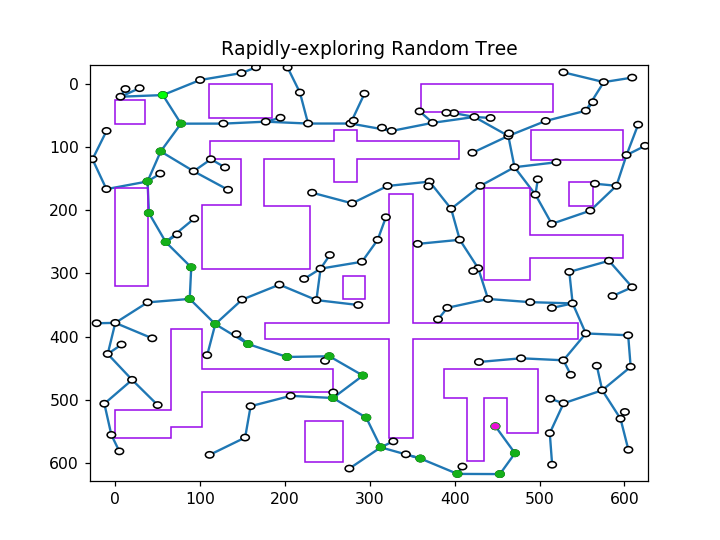

In [10]:
fig, ax = plt.subplots()
draw_obstacle_course(path, ax)
draw_start_and_goal(start, goal, ax)
circ_rad = min(step_size/5, 5)
plt.ion()
plt.show()

# Plot out results
for node in RRT.dict:    
    ax.add_patch(patches.Circle(node, circ_rad, edgecolor='k', facecolor='w', zorder=1))

    for end in RRT[node].children:
        ax.add_line(Line2D((node[0], end[0]), (node[1], end[1]), zorder=0))

cur = RRT[goal]
while cur:
    ax.add_patch(patches.Circle(cur, 5, color='xkcd:green', zorder=2))
    cur = cur.parent

In [11]:
# Bi-directional RRT
# obstacle_path, goal_path = "../hw3/world_obstacles.txt", "../hw3/goal.txt"
obstacle_path, goal_path = "world_obstacles.txt", "start_goal.txt"

step_size   = 50
path        = get_obstacle_course(obstacle_path)
start, goal = get_start_and_goal(goal_path)
obstacles   = Obstacles(path.to_polygons())
ends        = [np.array(goal), np.array(start)]

near_count  = 0
minp, maxp  = path.vertices.min(0), path.vertices.max(0)
span        = maxp - minp
gen_rand    = lambda: np.random.random(2) * span*1.1 + minp - span*0.05

KD  = [KDTree.KDTree(start), KDTree.KDTree(goal)]
RRT = [PathTree(start), PathTree(goal)]
n   = 1

"""
• Expand tree T_1 randomly, add node q_new
• Expand T_2 towards q_new
    • If tree T_2 connects to q_new, path formed else add a q_new for tree T_2
• Now expand T_1 to q_new in tree T_2
• Keep swapping T_1 and T_2 for expansion towards the
other tree until they meet
"""
q_new, last_expanded = None, -1

while KD[0].length + KD[1].length < 1000:
    n = 1 - n
    
    # If the last expanded node was in the other tree, try expanding towards q_new
    if last_expanded != n and q_new is not None:
        q_near, dist = KD[n].nearestNode(q_new)
        q_next = gen_next(q_near, q_new, step_size) if dist>step_size else q_new
        if not obstacles.point_is_valid(*q_next): continue
        
        # Expansion towards q_new is possible. Add to path and goal check
        if not obstacles.check_collisions((q_near, q_next)):
            RRT[n].addPath(q_near, q_next)
            KD[n].addNode(q_next)
            
            if q_next == q_new: break # Path found
            q_new, last_expanded, near_count = q_next, n, 0 # Update for next iteration
            continue

    # If last expanded node was not in the other tree or expansion to q_new not possible
    # Try to expand to q_rand if possible
    q_rand = gen_valid_rand(obstacles.point_is_valid) if np.random.randint(0,100)>5 else ends[n]

    q_near, dist = KD[n].nearestNode(q_rand)
    if dist < step_size:
        near_count += 1
        if near_count < 10: continue
        q_next = tuple(q_rand)
    else:
        q_next = gen_next(q_near, q_rand, step_size)
        if not obstacles.point_is_valid(*q_next): continue
    
    if obstacles.check_collisions((q_near, q_next)): continue
    
    KD[n].addNode(q_next)
    RRT[n].addPath(q_near, q_next)
    q_new, last_expanded, near_count = q_next, n, 0

print("n =", KD[0].length + KD[1].length, "(%d, %d)"%(KD[0].length, KD[1].length))

n = 57 (50, 7)


<IPython.core.display.Javascript object>


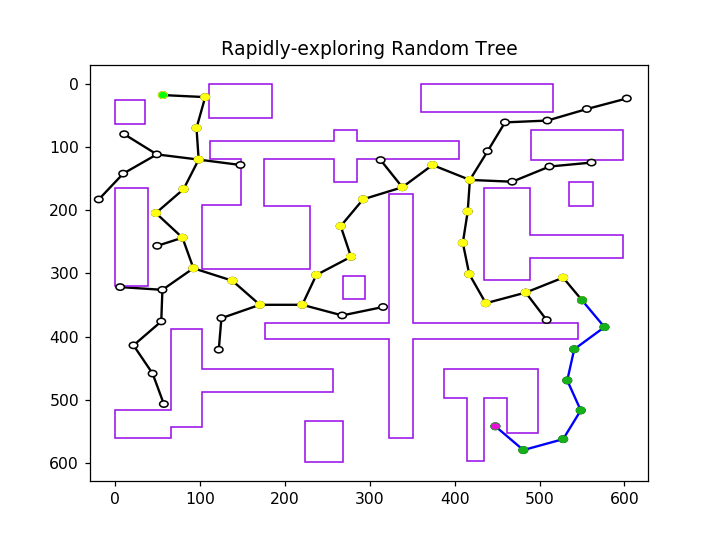

In [12]:
fig, ax = plt.subplots()
draw_obstacle_course(path, ax)
draw_start_and_goal(start, goal, ax)
circ_rad = min(step_size/5, 5)

# Plot out results for each tree
for node in RRT[0].dict:
    ax.add_patch(patches.Circle(node, circ_rad, edgecolor='k', facecolor='w', zorder=1))

    for end in RRT[0][node].children:
        ax.add_line(Line2D((node[0], end[0]), (node[1], end[1]), color='k', zorder=0))

for node in RRT[1].dict:    
    ax.add_patch(patches.Circle(node, circ_rad, edgecolor='k', facecolor='w', zorder=1))

    for end in RRT[1][node].children:
        ax.add_line(Line2D((node[0], end[0]), (node[1], end[1]), color='b', zorder=0))

# Plot out goal path
cur = RRT[0][tuple(q_next)]
while cur:
    ax.add_patch(patches.Circle(cur, circ_rad, color='xkcd:yellow', zorder=2))
    cur = cur.parent

cur = RRT[1][tuple(q_next)]
while cur:
    ax.add_patch(patches.Circle(cur, circ_rad, color='xkcd:green', zorder=2))
    cur = cur.parent